In [ ]:
import numpy as np
import pandas as pd
import pickle 

import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sns


# Loading Data

In [2]:
def load_pickle_data(path:str)->pd.DataFrame:
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

In [3]:
df = load_pickle_data("data/df_train.pkl")
embeddings = df["business_description_embedding"].apply(ast.literal_eval).tolist()

In [4]:
df.head(3)

,id,industry,business_description_embedding
38532,42576,Banks,"[0.03411475,-0.03753958,0.023233214,-0.0017205..."
19838,21752,Materials,"[-0.025557408,0.0636078,-0.01350581,-0.0180223..."
904,804,Commercial & Professional Services,"[0.033574868,-0.020379327,-0.03221274,-0.01133..."


# Transforming Data (Label Encoding)

### Tasks:
- Use the scikit-learn label encoder to encode the industry names
- Check if all classes contained in the validation set are also in the training set

In [4]:
df_train, df_val = train_test_split(df, test_size= 0.2, random_state=42)

X_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_train = np.array(X_train)

X_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_val = np.array(X_val)

In [5]:
# Fit the label encoder to the classes (industry names)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['industry'])
y_val = label_encoder.transform(df_val['industry'])

In [6]:
# Check if all classes contained in the validation set are also in the training set
assert set(y_val).issubset(set(y_train)), "Validation set contains unseen classes!"

#

# Visualize the data

### Tasks:
- Are certain classes over- or under represented? Either produce a table or a plot to show this.
- Inspect whether there is signal in the business description embeddings:
    - Perform a PCA to project data into 2 dimensions
    - Plot projected data in Scatterplot and color based on classes
    - Provide a description of what you see and judge whether there is signal in the data that allows industry classification

Important: Ensure that your plots have proper axis descriptions and titles. Style the plots so that differences in class distributions are visible (e.g. scatter size, transparency, color, etc.)

### Class distribution

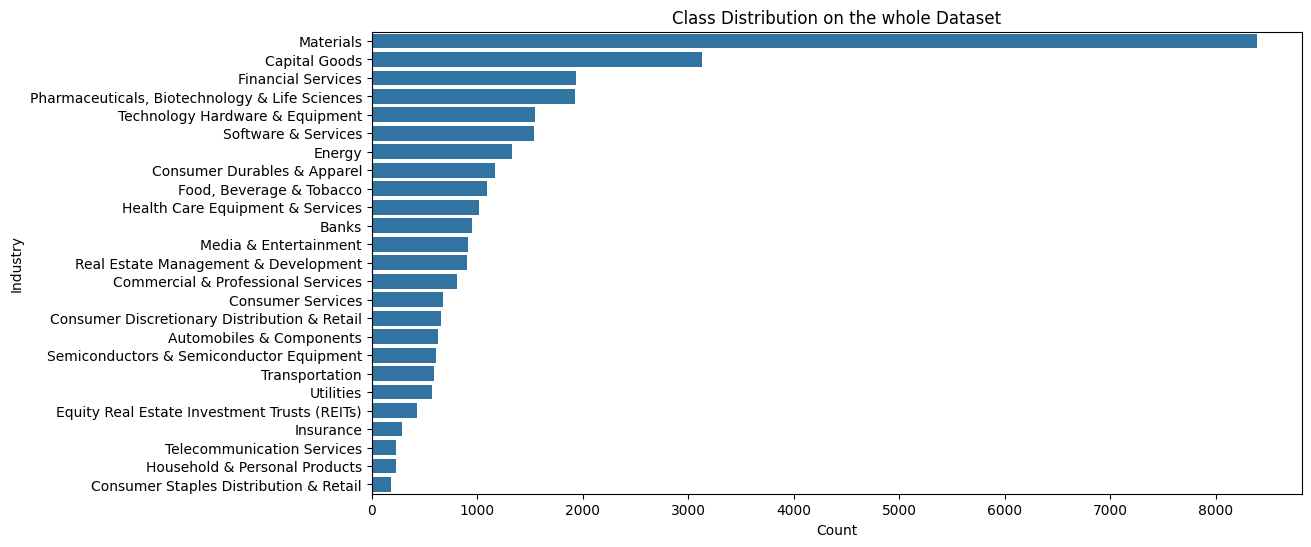

In [7]:
# Plot the class distribution or provide a table that shows how many times each class (industry) appears
plt.figure(figsize=(12, 6))

sns.countplot(y=df['industry'], order=df['industry'].value_counts().index)
plt.title('Class Distribution on the whole Dataset')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.show() 

### Describe your findings

Based on the class distribution plot, we can observe that certain industries are significantly overrepresented in the dataset (Materials and Capital Goods), while others have very few samples (Consumer Staples Distribution & Retail, Household & Personal Products, Insurance and Telecommunication Services). This imbalance could potentially affect the performance of classification models, as they may become biased towards the majority classes. It is important to consider techniques such as resampling or class weighting to address this issue during model training.

### PCA - Dimensionality reduction and visualization

Optimal Dimensionality Reduction Analysis:
Original dimensionality: 768

To retain 80% variance:
  → Need 80 components
  → Compression: 89.6% reduction
  → Actual variance retained: 80.02%

To retain 85% variance:
  → Need 109 components
  → Compression: 85.8% reduction
  → Actual variance retained: 85.09%

To retain 90% variance:
  → Need 151 components
  → Compression: 80.3% reduction
  → Actual variance retained: 90.07%

To retain 95% variance:
  → Need 224 components
  → Compression: 70.8% reduction
  → Actual variance retained: 95.02%

To retain 99% variance:
  → Need 425 components
  → Compression: 44.7% reduction
  → Actual variance retained: 99.00%



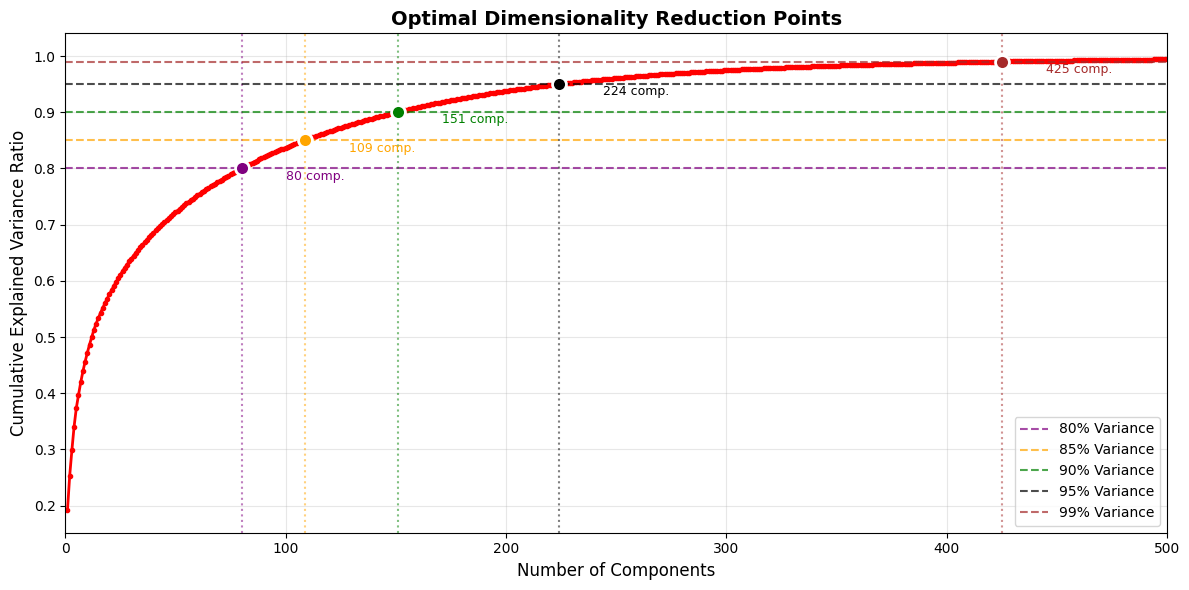

In [8]:
# Perform PCA and plot the projected data. Color the scatter plot based on the classes
pca = PCA()
pca.fit(embeddings)

# Find optimal number of components for different variance thresholds
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find components needed for different variance levels
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
print("Optimal Dimensionality Reduction Analysis:")
print("=" * 60)
print(f"Original dimensionality: {len(pca.explained_variance_ratio_)}")
print()

for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    compression_ratio = (1 - n_components / len(pca.explained_variance_ratio_)) * 100
    print(f"To retain {threshold*100:.0f}% variance:")
    print(f"  → Need {n_components} components")
    print(f"  → Compression: {compression_ratio:.1f}% reduction")
    print(f"  → Actual variance retained: {cumulative_variance[n_components-1]*100:.2f}%")
    print()

# Visualization: Mark optimal points on the cumulative plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2, markersize=3)

colors = ['purple', 'orange', 'green', 'black', 'brown']
for threshold, color in zip(variance_thresholds, colors):
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.7, label=f'{threshold*100:.0f}% Variance')
    plt.axvline(x=n_components, color=color, linestyle=':', alpha=0.5)
    plt.plot(n_components, threshold, 'o', color=color, markersize=10, markeredgecolor='white', markeredgewidth=2)
    plt.text(n_components + 20, threshold - 0.02, f'{n_components} comp.', fontsize=9, color=color)

plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.title('Optimal Dimensionality Reduction Points', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, min(500, len(cumulative_variance)))  
plt.tight_layout()
plt.show()

### Dimensionality reduction with PCA

From the plot above we can see that to retain 90% of the variance in the data, we need to keep around 100 principal components. This indicates that the original 768-dimensional embeddings can be effectively reduced to a lower-dimensional space while still preserving most of the information. Reducing the dimensionality can help improve computational efficiency and potentially enhance the performance of machine learning models by eliminating noise and redundant features as well as boost model performance and interpretability. This also means that the embeddings contain a lot of redundant information.

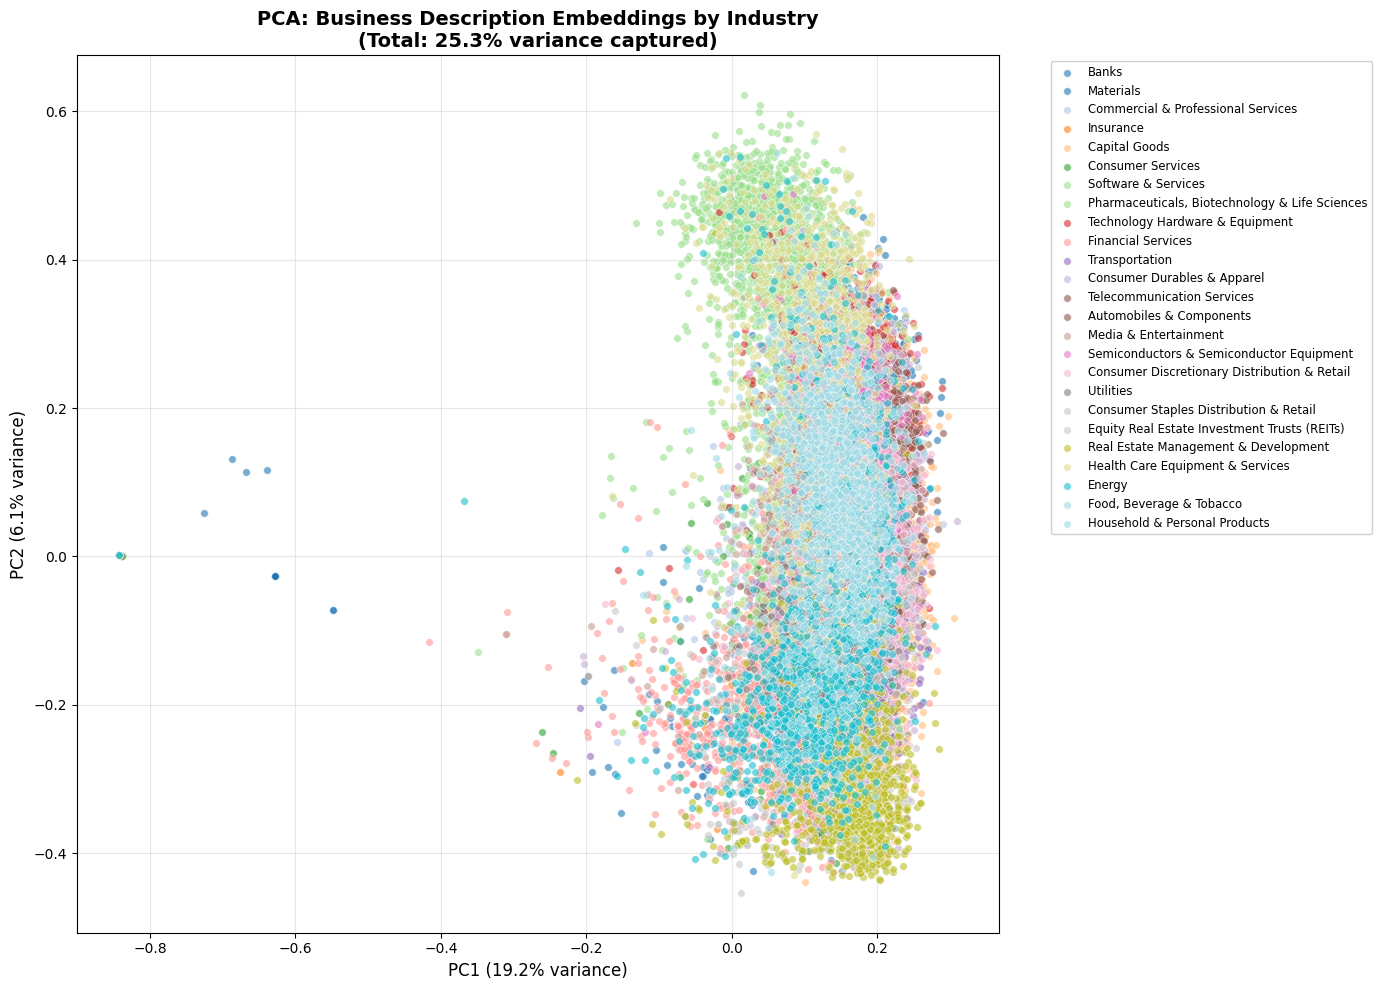

PC1 variance: 19.23%
PC2 variance: 6.08%
Total variance captured in 2D: 25.32%

This means we're losing 74.68% of information


In [9]:
# Fit PCA with only 2 components for efficiency
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings)

# Create the scatter plot
plt.figure(figsize=(14, 10))

# Get unique industries and create a color palette
unique_industries = df['industry'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_industries)))

# Create scatter plot with different colors for each industry
for i, industry in enumerate(unique_industries):
    mask = df['industry'] == industry
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
               c=[colors[i]], label=industry, alpha=0.6, s=30, edgecolors='w', linewidth=0.5)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'PCA: Business Description Embeddings by Industry\n(Total: {pca_2d.explained_variance_ratio_.sum():.1%} variance captured)', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"PC1 variance: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"PC2 variance: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"Total variance captured in 2D: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"\nThis means we're losing {1 - pca_2d.explained_variance_ratio_.sum():.2%} of information")

### Scatter plot of PCA projected data

Based on the PCA scatter plot, we can observe that there is some clustering of data points based on their industry classes, indicating that the business description embeddings do contain some signal that can be used for industry classification. However, there is also a significant amount of overlap between different classes, suggesting that the embeddings may not be perfectly separable in this 2D space. This overlap could pose challenges for classification models, as they may struggle to distinguish between certain industries. Overall, while there is some signal in the data, further analysis and potentially more advanced techniques may be needed to effectively classify industries based on these embeddings. One approach could be to reduce the dimensions based on the explained variance ratio and then apply clustering algorithms to identify distinct groups within the data. This could help to better understand the underlying structure of the embeddings and potentially improve classification performance.

# Fitting and comparing Classifier Models

### Tasks:
- Split the data into train and validation data
- Encode the industry labels using LabelEncoder (scikit-learn)
- Fit a LogisticRegression and a kNN-classifier
- Compare the performance of both models:
    - Compute Accuracy and F1 score
        - Interpret the scores: Explain how they are computed and judge if your model performs well
        - Analyze the classification errors: 
            - Do the errors correlate with how well classes are represented?
            - Which industries does the model identify well and which seem to be similar?
    - Plot a confusion matrix for both models (combine scikit-learn confusion matrix and seaborn heatmap plot)
    - Do both models misclassify the same examples?

Import: Use proper axis labels for the plots! 

In [10]:
# Reduce to 90% variance (approximately 151 components based on the PCA analysis)
pca_90 = PCA(n_components=0.90, random_state=42)  
X_train_reduced = pca_90.fit_transform(X_train)
X_val_reduced = pca_90.transform(X_val)

In [12]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)
lr_model.fit(X_train_reduced, y_train)

Training Logistic Regression...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
# Train kNN Classifier
print("Training kNN Classifier...")
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',  
    metric='cosine'  
)
knn_model.fit(X_train_reduced, y_train)


Training kNN Classifier...


,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [14]:
from sklearn.model_selection import cross_val_score
import math

# Define range based on dataset
n_samples = len(X_train_reduced)
k_max = min(int(math.sqrt(n_samples)), 31)
k_range = range(3, k_max, 2)  # Odd numbers only

print(f"Testing k values from 3 to {k_max-1}...")

# Quick cross-validation test
cv_results = []
for k in k_range:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='cosine'
    )
    # 5-fold cross-validation
    scores = cross_val_score(knn, X_train_reduced, y_train, 
                            cv=5, scoring='f1_macro', n_jobs=-1)
    cv_results.append({
        'k': k,
        'mean_f1': scores.mean(),
        'std_f1': scores.std()
    })
    
# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(cv_results)
results_df = results_df.sort_values('mean_f1', ascending=False)

print("\nTop 5 k values by cross-validation F1 score:")
print(results_df.head())

# Select best k
best_k = results_df.iloc[0]['k']
print(f"\nOptimal k: {int(best_k)}")

# Train final model with optimal k
print(f"\nTraining kNN with optimal k={int(best_k)}...")
knn_model = KNeighborsClassifier(
    n_neighbors=int(best_k),
    weights='distance',  
    metric='cosine'
)
knn_model.fit(X_train_reduced, y_train)

Testing k values from 3 to 30...

Top 5 k values by cross-validation F1 score:
    k   mean_f1    std_f1
8  19  0.703085  0.011052
4  11  0.702524  0.010882
6  15  0.702251  0.012232
5  13  0.701938  0.010118
7  17  0.701794  0.009797

Optimal k: 19

Training kNN with optimal k=19...


,n_neighbors,19
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [15]:
# Predictions
y_pred_lr = lr_model.predict(X_val_reduced)
y_pred_knn = knn_model.predict(X_val_reduced)

In [16]:
# Compute metrics
print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_f1_macro = f1_score(y_val, y_pred_lr, average='macro')
lr_f1_weighted = f1_score(y_val, y_pred_lr, average='weighted')

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score (Macro): {lr_f1_macro:.4f}")
print(f"F1 Score (Weighted): {lr_f1_weighted:.4f}")

print("\n" + "="*60)
print("kNN RESULTS")
print("="*60)
knn_accuracy = accuracy_score(y_val, y_pred_knn)
knn_f1_macro = f1_score(y_val, y_pred_knn, average='macro')
knn_f1_weighted = f1_score(y_val, y_pred_knn, average='weighted')

print(f"Accuracy: {knn_accuracy:.4f}")
print(f"F1 Score (Macro): {knn_f1_macro:.4f}")
print(f"F1 Score (Weighted): {knn_f1_weighted:.4f}")


LOGISTIC REGRESSION RESULTS
Accuracy: 0.7364
F1 Score (Macro): 0.6819
F1 Score (Weighted): 0.7398

kNN RESULTS
Accuracy: 0.7788
F1 Score (Macro): 0.7095
F1 Score (Weighted): 0.7724


### Model Evaluation

We rely on the F1 Macro score to evaluate the model performance. The F1 Macro score is the unweighted mean of the F1 scores for each class, treating all classes equally regardless of their support (number of true instances for each class). This metric is particularly useful in scenarios with imbalanced class distributions, as it ensures that the performance on minority classes is given equal importance as that on majority classes.

F1 Macro formula:
F1 Macro = (1/C) * Σ (2 * (precision_i * recall_i) / (precision_i + recall_i))
where C is the number of classes, and precision_i and recall_i are the precision and recall for class i.

Looking at the confusion matrices, there's a clear correlation between classification errors and class representation:

Well-represented classes (Materials, Capital Goods) show higher diagonal values (better accuracy)
Under-represented classes (Consumer Staples Distribution & Retail, Insurance, Telecommunication Services) show poor performance with many off-diagonal predictions
This suggests that the model's performance is not only influenced by its accuracy but also by how it handles class imbalance. The model tends to misclassify instances from minority classes into majority classes, indicating a bias towards the latter.

Both models perform relatively well on:

Materials: High diagonal values (~60-70%)
Capital Goods: Decent performance (~40-50%)
Commercial & Professional Services: Moderate success

Both models struggle to distinguish between:

Financial Services and Commercial & Professional Services
Technology Hardware & Equipment and Semiconductors & Semiconductor Equipment
Consumer Discretionary Distribution & Retail and Consumer Staples Distribution & Retail
Energy companies often misclassified as Materials or Utilities

Comparing the two confusion matrices, both models show:

Similar error patterns for under-represented classes
Both struggle with the same industry pairs
kNN appears slightly more prone to spreading predictions across multiple classes
Logistic Regression tends to be more decisive but sometimes wrong

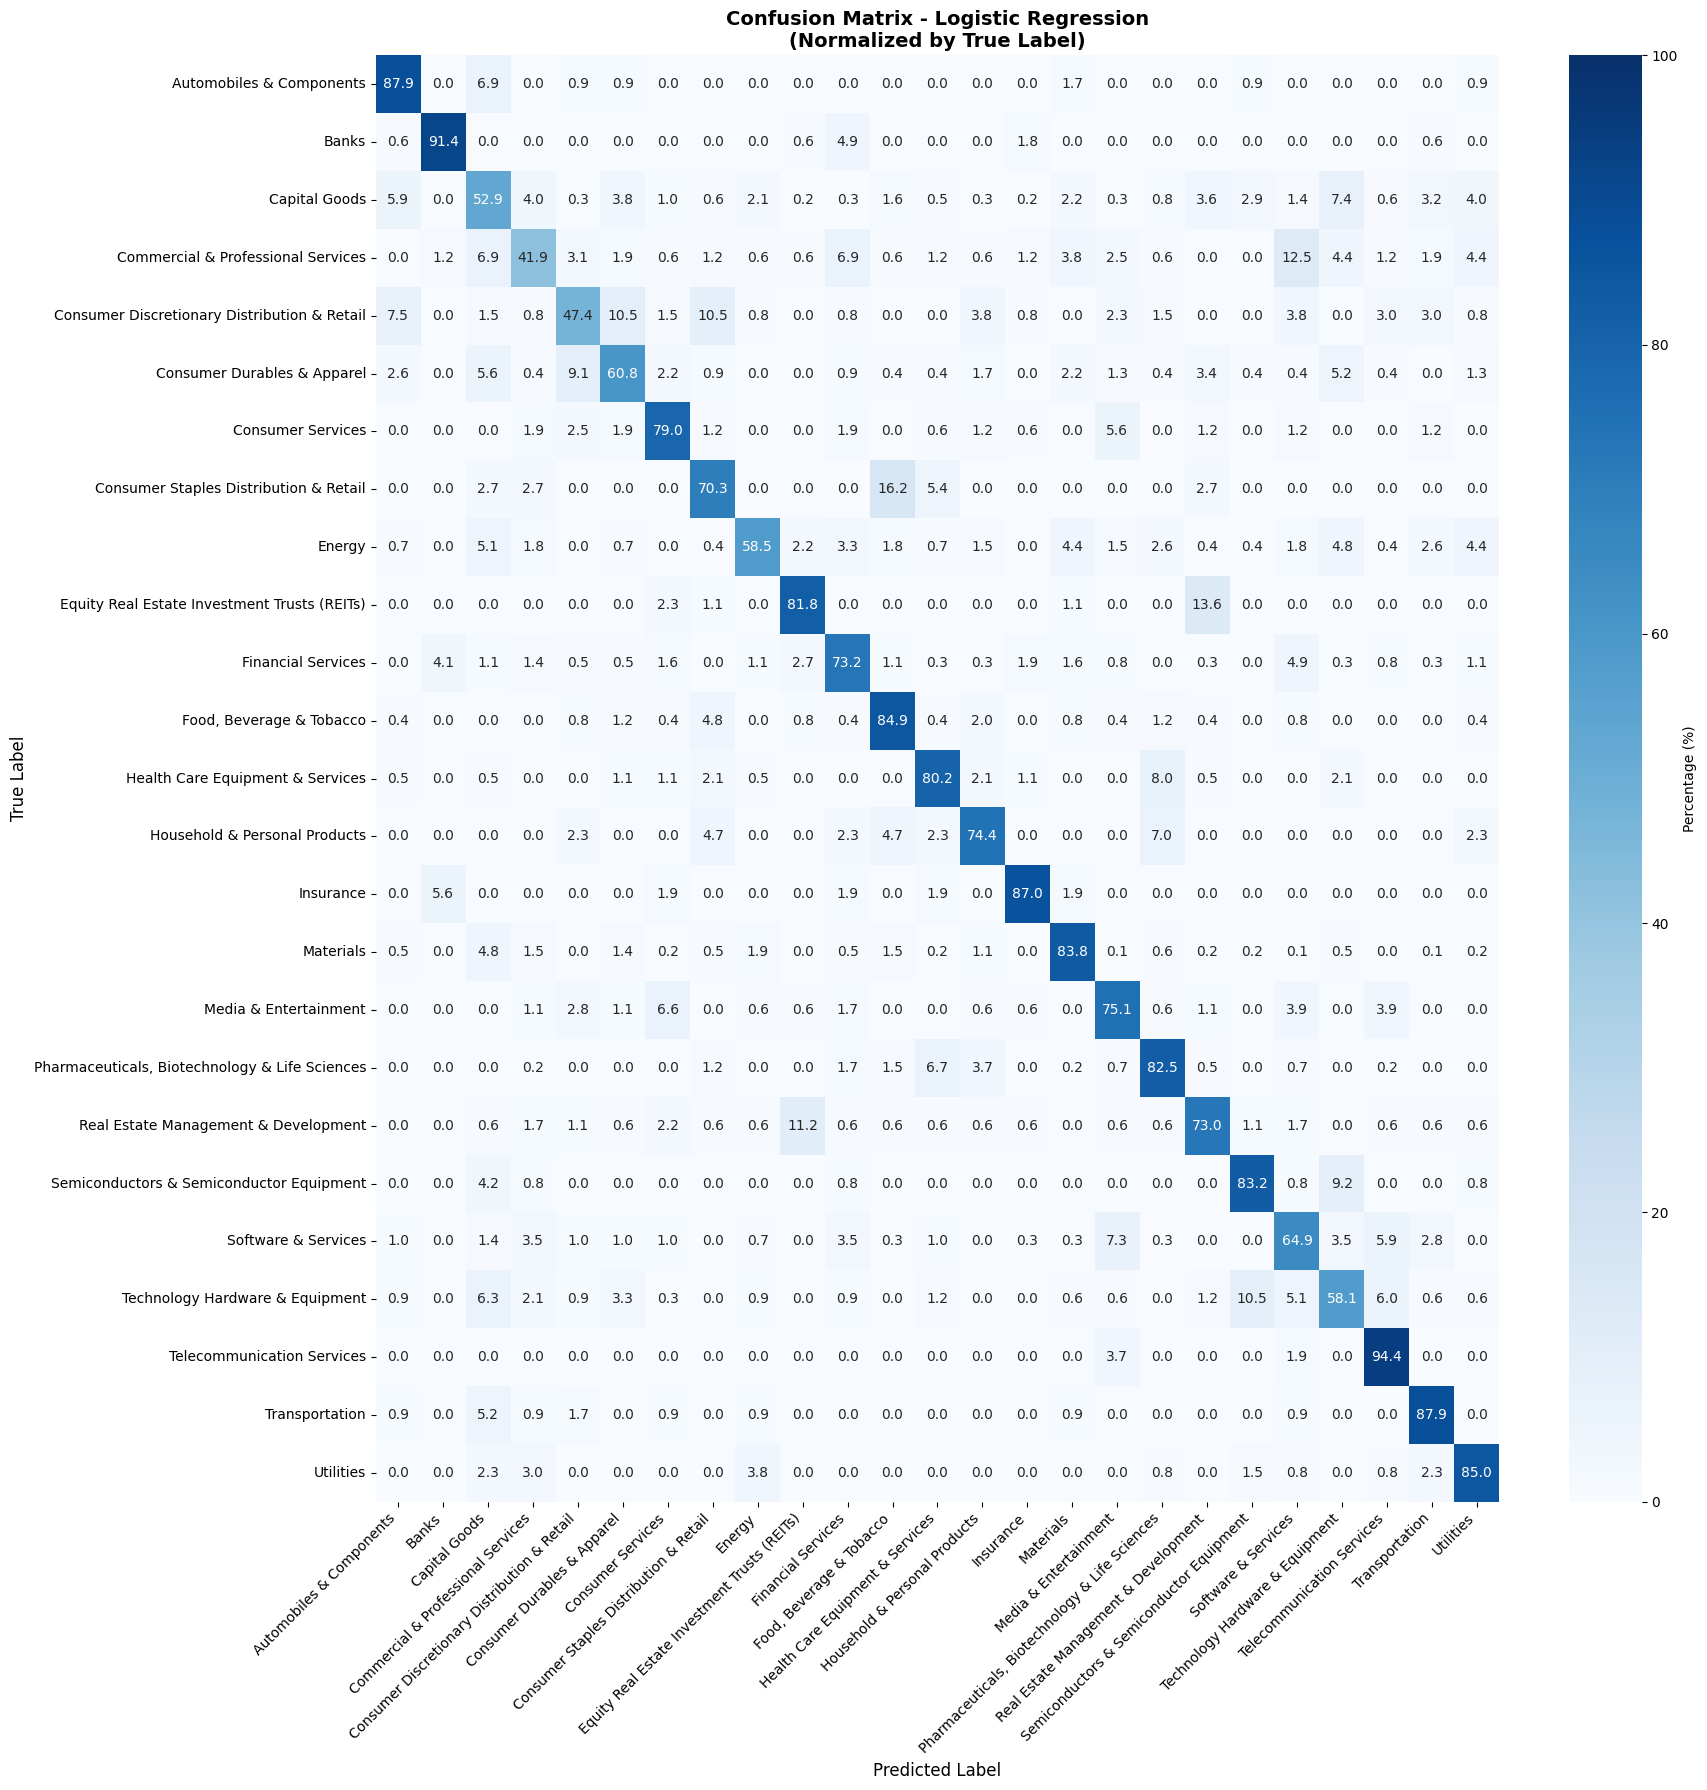

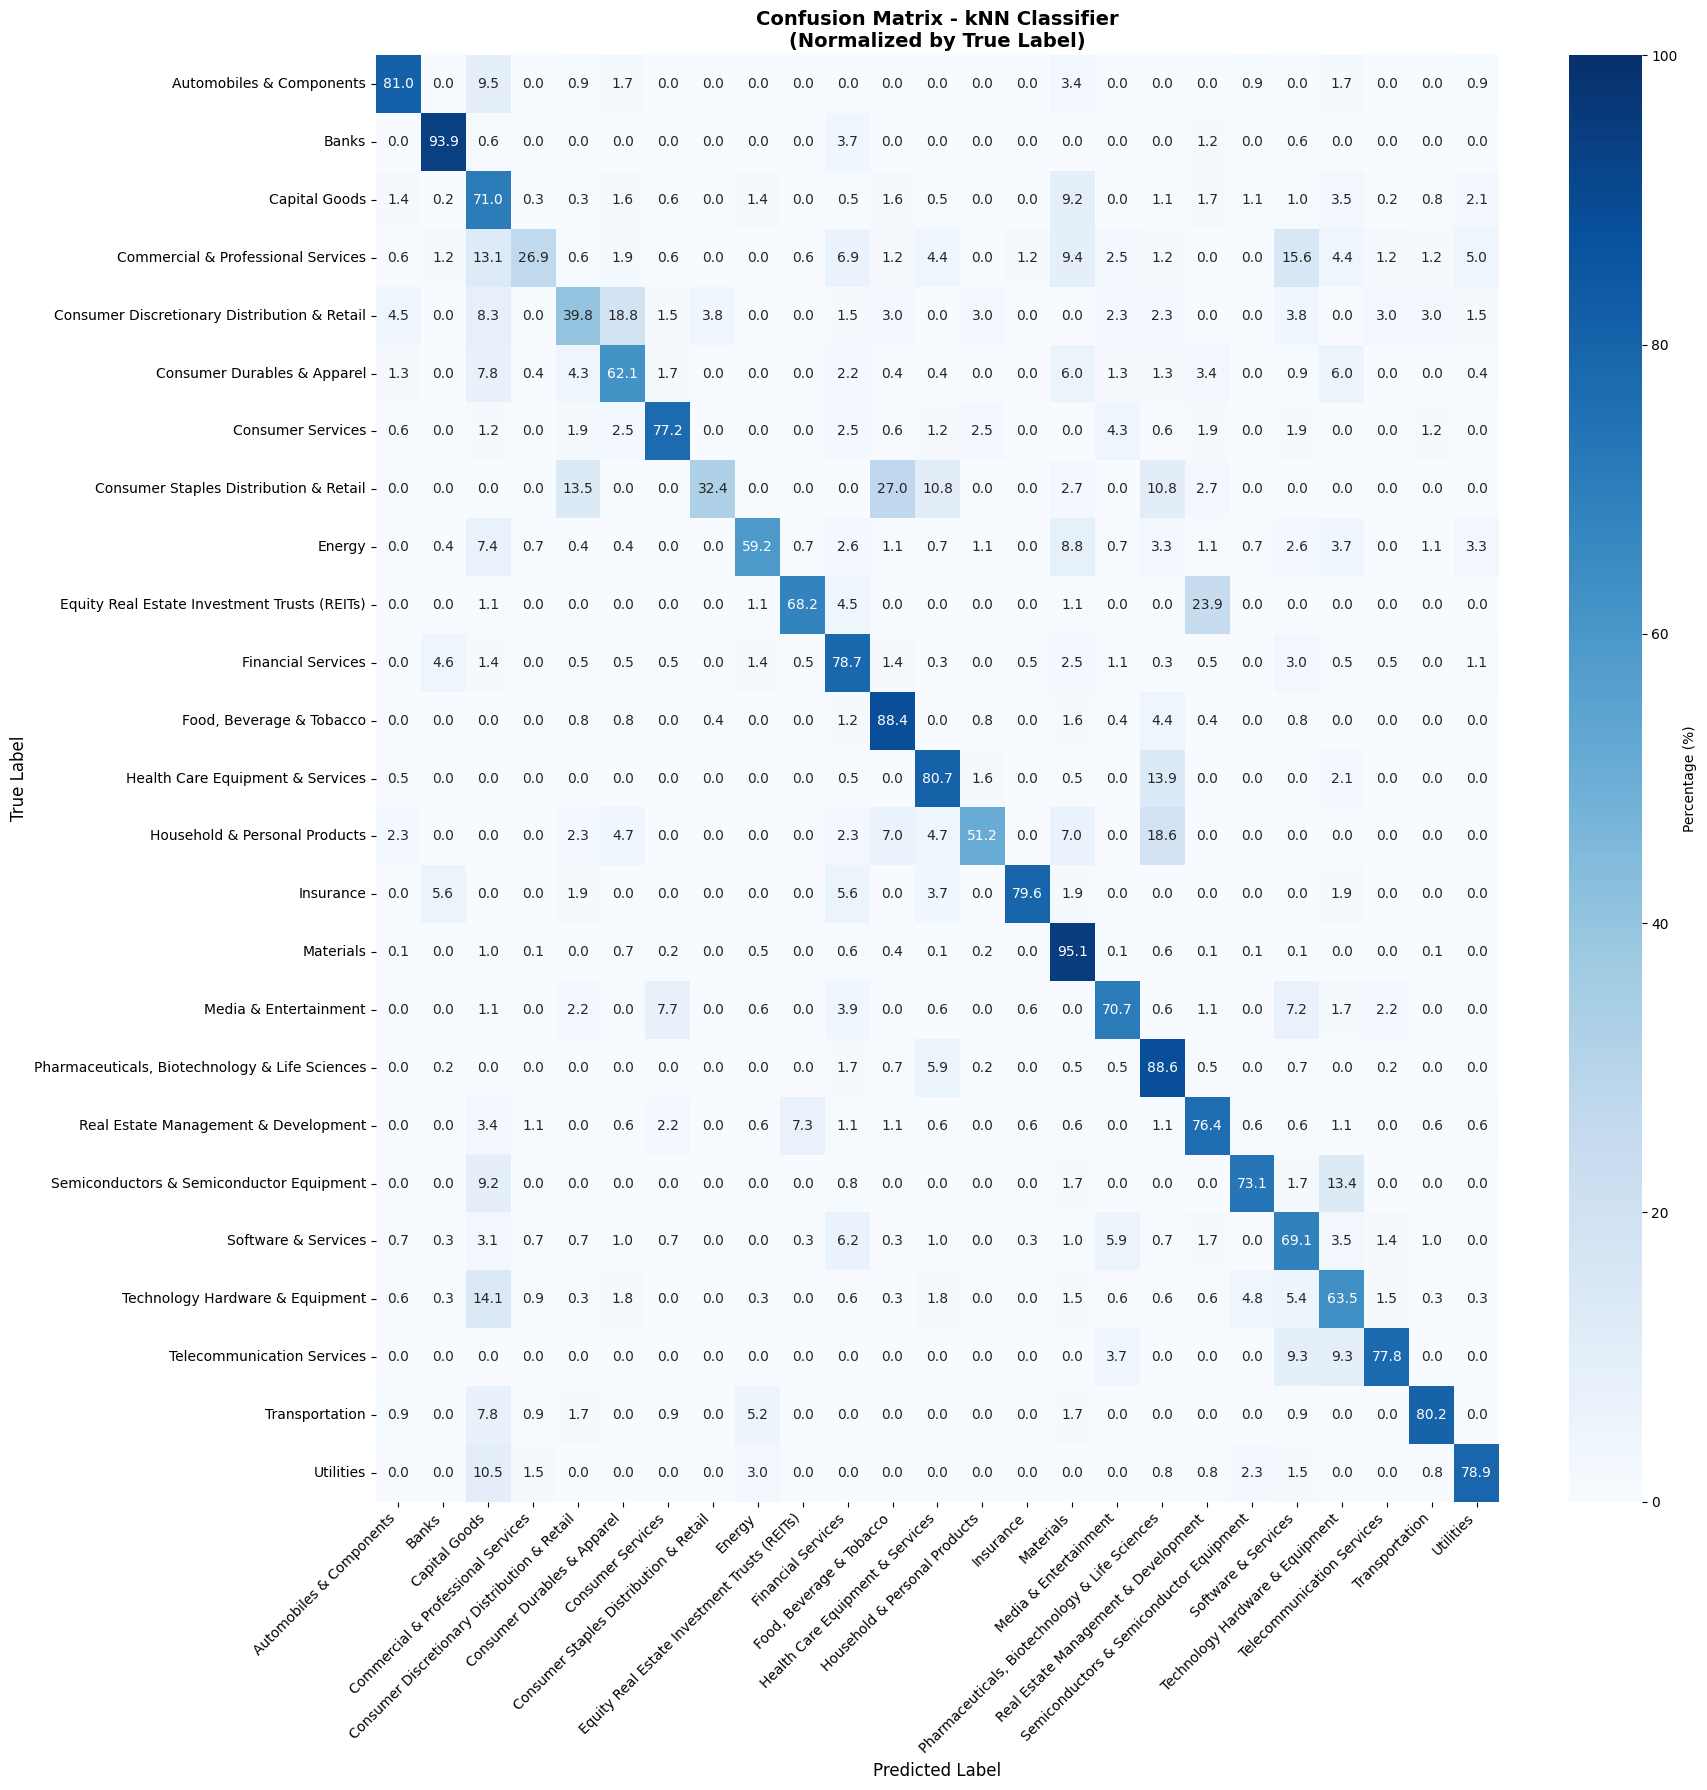

In [17]:
def plot_confusion_matrix_sklearn(y_true, y_pred, title, label_encoder):
    """Plot confusion matrix using sklearn's normalize parameter"""
    
    # Calculate normalized confusion matrix
    cm_percent = confusion_matrix(y_true, y_pred, normalize='true') * 100
    
    plt.figure(figsize=(18, 18))
    sns.heatmap(
        cm_percent, 
        annot=True, 
        fmt='.1f', 
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        cbar_kws={'label': 'Percentage (%)'},
        vmin=0,
        vmax=100
    )
    plt.title(f'{title}\n(Normalized by True Label)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrix_sklearn(y_val, y_pred_lr, 
                     'Confusion Matrix - Logistic Regression', 
                     label_encoder)

plot_confusion_matrix_sklearn(y_val, y_pred_knn, 
                     'Confusion Matrix - kNN Classifier', 
                     label_encoder)

# Optional: Confidence Weighted Prediction

## Deliverables:

- Provide a notebook with the implementation and training of an industry classifier model
- The model shall output the industry classification and its confidence as a tuple of vectors $(\hat{y}_{pred}, \hat{y}_{confidence})$
- The confidence score must be between 0 and 1, $\hat{y}_{confidence} [i] \in [0,1]$
- Your model will be evaluated on a private test set
- The designing the confidence score is your task. You may use p-values, a voting mechanism of multiple models, or other techniques
- Another option is to add more features, e.g. financial data, to X

In [18]:
def confidence_weighted_f1(y_true, y_pred, confidence):
    # Weight all predictions, not just positives
    weighted_tp = np.sum(confidence * (y_pred == 1) * (y_true == 1))
    weighted_fp = np.sum(confidence * (y_pred == 1) * (y_true == 0))
    weighted_fn = np.sum(confidence * (y_pred == 0) * (y_true == 1))
    
    precision = weighted_tp / (weighted_tp + weighted_fp) if (weighted_tp + weighted_fp) > 0 else 0
    recall = weighted_tp / (weighted_tp + weighted_fn) if (weighted_tp + weighted_fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

In [19]:
import numpy as np
import pandas as pd
import ast
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [20]:
class AdvancedFinancialFeatureProcessor:
    """
    Advanced feature processor for financial data with comprehensive handling of:
    - Missing values (NaN, inf, -inf)
    - Outliers (using multiple strategies)
    - Negative values in ratio features
    - Industry-specific normalization
    """
    
    def __init__(self, features_to_use, outlier_method='iqr', outlier_threshold=3.0):
        """
        Parameters:
        -----------
        features_to_use : list
            List of feature names to process
        outlier_method : str
            Method for outlier detection: 'iqr', 'zscore', 'percentile'
        outlier_threshold : float
            Threshold for outlier detection (IQR multiplier or z-score threshold)
        """
        self.features_to_use = features_to_use
        self.outlier_method = outlier_method
        self.outlier_threshold = outlier_threshold
        
        # Statistical storage
        self.industry_stats = {}
        self.global_stats = {}
        self.outlier_bounds = {}
        self.scaler = None
        
    def fit(self, df_financial):
        """
        Fit the processor on training data
        
        Parameters:
        -----------
        df_financial : pd.DataFrame
            DataFrame with 'industry' column and financial features
        """
        print("Fitting AdvancedFinancialFeatureProcessor...")
        
        # Step 1: Calculate statistics for each feature
        for feature in self.features_to_use:
            print(f"  Processing feature: {feature}")
            
            # Industry-specific statistics
            self.industry_stats[feature] = {
                'median': df_financial.groupby('industry')[feature].median(),
                'mean': df_financial.groupby('industry')[feature].mean(),
                'std': df_financial.groupby('industry')[feature].std()
            }
            
            # Global statistics (for fallback)
            valid_values = df_financial[feature].replace([np.inf, -np.inf], np.nan).dropna()
            
            self.global_stats[feature] = {
                'median': valid_values.median(),
                'mean': valid_values.mean(),
                'std': valid_values.std(),
                'q25': valid_values.quantile(0.25),
                'q75': valid_values.quantile(0.75)
            }
            
            # Calculate outlier bounds
            self.outlier_bounds[feature] = self._calculate_outlier_bounds(valid_values)
        
        # Step 2: Apply full preprocessing pipeline to training data
        feature_matrix = self._preprocess(df_financial)
        
        # Step 3: Fit scaler on cleaned data
        self.scaler = RobustScaler()
        feature_matrix = self.scaler.fit_transform(feature_matrix)
        
        print("Fitting complete\n")
        return feature_matrix
    
    def transform(self, df_financial):
        """
        Transform new data using fitted statistics
        """
        if self.scaler is None:
            raise ValueError("Must call fit() before transform()")
        
        feature_matrix = self._preprocess(df_financial)
        feature_matrix = self.scaler.transform(feature_matrix)
        
        return feature_matrix
    
    def _calculate_outlier_bounds(self, values):
        """
        Calculate outlier bounds based on specified method
        """
        if self.outlier_method == 'iqr':
            q25, q75 = values.quantile(0.25), values.quantile(0.75)
            iqr = q75 - q25
            lower_bound = q25 - self.outlier_threshold * iqr
            upper_bound = q75 + self.outlier_threshold * iqr
            
        elif self.outlier_method == 'zscore':
            mean, std = values.mean(), values.std()
            lower_bound = mean - self.outlier_threshold * std
            upper_bound = mean + self.outlier_threshold * std
            
        elif self.outlier_method == 'percentile':
            lower_bound = values.quantile(0.01)
            upper_bound = values.quantile(0.99)
            
        else:
            raise ValueError(f"Unknown outlier method: {self.outlier_method}")
        
        return {'lower': lower_bound, 'upper': upper_bound}
    
    def _preprocess(self, df_financial):
        """
        Main preprocessing pipeline:
        1. Handle infinite values
        2. Impute missing values (industry-aware)
        3. Handle outliers
        4. Handle negative values in ratio features
        """
        feature_matrix = df_financial[self.features_to_use].values.copy().astype(float)
        
        for i, row_idx in enumerate(df_financial.index):
            industry = df_financial.loc[row_idx, 'industry']
            
            for j, feature in enumerate(self.features_to_use):
                value = feature_matrix[i, j]
                
                # Step 1: Handle inf/-inf
                if np.isinf(value):
                    value = np.nan
                
                # Step 2: Impute missing values
                if np.isnan(value):
                    value = self._impute_value(feature, industry)
                
                # Step 3: Handle outliers 
                value = self._handle_outlier(feature, value)
                
                # Step 4: Domain-specific constraints
                if 'margin' in feature.lower() or 'turnover' in feature.lower():
                    if value < -1:
                        value = -1
                    elif value > 5:
                        value = 5
                
                feature_matrix[i, j] = value
        
        # Final safety check
        feature_matrix = np.nan_to_num(feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)
        
        return feature_matrix
    
    def _impute_value(self, feature, industry):
        """
        Impute missing value using industry median, or global median as fallback
        """
        # Try industry median first
        if industry in self.industry_stats[feature]['median'].index:
            imputed_value = self.industry_stats[feature]['median'][industry]
            
            # Check if industry median is valid
            if not np.isnan(imputed_value) and not np.isinf(imputed_value):
                return imputed_value
        
        # Fallback to global median
        return self.global_stats[feature]['median']
    
    def _handle_outlier(self, feature, value):
        """
        Cap outliers at computed bounds
        """
        bounds = self.outlier_bounds[feature]
        
        if value < bounds['lower']:
            return bounds['lower']
        elif value > bounds['upper']:
            return bounds['upper']
        else:
            return value
    
    def get_feature_statistics(self):
        """
        Return summary statistics for inspection
        """
        summary = {}
        for feature in self.features_to_use:
            summary[feature] = {
                'global_median': self.global_stats[feature]['median'],
                'global_mean': self.global_stats[feature]['mean'],
                'outlier_bounds': self.outlier_bounds[feature]
            }
        return summary

In [21]:
class HybridEnsembleClassifier:
    """
    Hybrid ensemble that combines:
    1. Multiple calibrated base classifiers
    2. Separate models for embeddings and financial features
    3. Intelligent confidence estimation
    """
    
    def __init__(self, n_classes, embedding_weight=0.6, financial_weight=0.4):
        """
        Parameters:
        -----------
        n_classes : int
            Number of target classes
        embedding_weight : float
            Weight for embedding-based predictions
        financial_weight : float
            Weight for financial feature-based predictions
        """
        self.n_classes = n_classes
        self.embedding_weight = embedding_weight
        self.financial_weight = financial_weight
        
        # Separate models for different feature types
        self.embedding_models = {}
        self.financial_models = {}
        self.combined_models = {}
        
    def fit(self, X_embeddings, X_financial, X_combined, y_train):
        """
        Train multiple model types on different feature sets
        """
        print("\n" + "="*60)
        print("Training Hybrid Ensemble Classifier")
        print("="*60)
        
        # 1. Models trained on embeddings only
        print("\n[1/3] Training embedding-specialized models...")
        self._fit_model_set(self.embedding_models, X_embeddings, y_train, 
                           model_types=['lr', 'rf'])
        
        # 2. Models trained on financial features only
        print("\n[2/3] Training financial-specialized models...")
        self._fit_model_set(self.financial_models, X_financial, y_train,
                           model_types=['lr', 'svc'])
        
        # 3. Models trained on combined features
        print("\n[3/3] Training combined-feature models...")
        self._fit_model_set(self.combined_models, X_combined, y_train,
                        model_types=['lr', 'rf', 'svc', 'knn']) 
        
        print("\n" + "="*60)
        print("Training Complete!")
        print("="*60 + "\n")
        
        return self
    
    def _fit_model_set(self, model_dict, X, y, model_types):
        """
        Helper to fit a set of model types
        """
        if 'lr' in model_types:
            print("  - Logistic Regression")
            lr = LogisticRegression(
                max_iter=1000, 
                random_state=42, 
                class_weight='balanced',
                C=1.0,
                solver='lbfgs'
            )
            model_dict['lr'] = CalibratedClassifierCV(lr, cv=3, method='sigmoid')
            model_dict['lr'].fit(X, y)
        
        if 'rf' in model_types:
            print("  - Random Forest")
            rf = RandomForestClassifier(
                n_estimators=200,
                max_depth=20,
                min_samples_split=10,
                min_samples_leaf=5,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            )
            model_dict['rf'] = CalibratedClassifierCV(rf, cv=3, method='sigmoid')
            model_dict['rf'].fit(X, y)
        
        if 'svc' in model_types:
            print("  - Linear SVC")
            svc = LinearSVC(
                C=0.1,
                max_iter=2000,
                class_weight='balanced',
                dual='auto',  # Automatically chooses based on n_samples vs n_features
                random_state=42
            )
            model_dict['svc'] = CalibratedClassifierCV(svc, cv=3, method='sigmoid')
            model_dict['svc'].fit(X, y)
        
        if 'knn' in model_types:
            print("  - k-Nearest Neighbors")
            knn = KNeighborsClassifier(
                n_neighbors=9,
                weights='distance',
                metric='cosine',
                n_jobs=-1
            )
            model_dict['knn'] = CalibratedClassifierCV(knn, cv=3, method='sigmoid')
            model_dict['knn'].fit(X, y)
    
    def predict_with_confidence(self, X_embeddings, X_financial, X_combined):
        """
        Predict with confidence scores using hybrid approach
        
        Returns:
        --------
        y_pred : array
            Predicted class labels
        y_confidence : array
            Confidence scores [0, 1]
        """
        n_samples = X_combined.shape[0]
        
        # Collect predictions from all model groups
        all_probs = []
        all_preds = []
        model_weights = []
        
        # 1. Embedding models
        for _, model in self.embedding_models.items():
            probs = model.predict_proba(X_embeddings)
            preds = model.predict(X_embeddings)
            all_probs.append(probs)
            all_preds.append(preds)
            model_weights.append(self.embedding_weight / len(self.embedding_models))
        
        # 2. Financial models
        for _, model in self.financial_models.items():
            probs = model.predict_proba(X_financial)
            preds = model.predict(X_financial)
            all_probs.append(probs)
            all_preds.append(preds)
            model_weights.append(self.financial_weight / len(self.financial_models))
        
        # 3. Combined models (already balanced weight)
        remaining_weight = 1.0 - self.embedding_weight - self.financial_weight
        for _, model in self.combined_models.items():
            probs = model.predict_proba(X_combined)
            preds = model.predict(X_combined)
            all_probs.append(probs)
            all_preds.append(preds)
            model_weights.append(remaining_weight / len(self.combined_models))
        
        all_probs = np.array(all_probs)  # Shape: (n_models, n_samples, n_classes)
        all_preds = np.array(all_preds)  # Shape: (n_models, n_samples)
        model_weights = np.array(model_weights)
        
        # Weighted probability averaging
        weighted_probs = np.zeros((n_samples, self.n_classes))
        for i, weight in enumerate(model_weights):
            weighted_probs += weight * all_probs[i]
        
        # Final prediction
        y_pred = np.argmax(weighted_probs, axis=1)
        
        # Confidence calculation
        confidence_scores = []
        
        for i in range(n_samples):
            # Component 1: Weighted model agreement
            weighted_agreement = np.sum(model_weights * (all_preds[:, i] == y_pred[i]))
            
            # Component 2: Probability of predicted class
            prob_pred_class = weighted_probs[i, y_pred[i]]
            
            # Component 3: Margin between top 2 classes
            sorted_probs = np.sort(weighted_probs[i])[::-1]
            margin = sorted_probs[0] - sorted_probs[1] if len(sorted_probs) > 1 else 1.0
            
            # Component 4: Entropy-based uncertainty
            entropy = -np.sum(weighted_probs[i] * np.log(weighted_probs[i] + 1e-10))
            max_entropy = np.log(self.n_classes)
            normalized_certainty = 1 - (entropy / max_entropy)
            
            # Weighted combination
            confidence = (
                0.25 * weighted_agreement +
                0.35 * prob_pred_class +
                0.20 * margin +
                0.20 * normalized_certainty
            )
            
            confidence_scores.append(np.clip(confidence, 0, 1))
        
        y_confidence = np.array(confidence_scores)
        
        return y_pred, y_confidence
    
    def evaluate(self, X_embeddings, X_financial, X_combined, y_true, label_encoder=None):
        """
        Comprehensive evaluation with detailed metrics
        """
        y_pred, y_confidence = self.predict_with_confidence(
            X_embeddings, X_financial, X_combined
        )
        
        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Confidence analysis
        correct_mask = (y_pred == y_true)
        avg_confidence = np.mean(y_confidence)
        avg_conf_correct = np.mean(y_confidence[correct_mask]) if correct_mask.any() else 0
        avg_conf_incorrect = np.mean(y_confidence[~correct_mask]) if (~correct_mask).any() else 0
        
        # Print results
        print("\n" + "="*60)
        print("EVALUATION RESULTS")
        print("="*60)
        print(f"\n{'Metric':<30} {'Value':>10}")
        print("-"*60)
        print(f"{'Accuracy':<30} {accuracy:>10.4f}")
        print(f"{'F1 Score (Macro)':<30} {f1_macro:>10.4f}")
        print(f"{'F1 Score (Weighted)':<30} {f1_weighted:>10.4f}")
        print("\n" + "-"*60)
        print("CONFIDENCE ANALYSIS")
        print("-"*60)
        print(f"{'Average Confidence':<30} {avg_confidence:>10.4f}")
        print(f"{'Confidence (Correct)':<30} {avg_conf_correct:>10.4f}")
        print(f"{'Confidence (Incorrect)':<30} {avg_conf_incorrect:>10.4f}")
        print(f"{'Confidence Gap':<30} {avg_conf_correct - avg_conf_incorrect:>10.4f}")
        print("="*60 + "\n")
        
        # Detailed classification report
        if label_encoder is not None:
            print("\nPer-Class Performance:")
            print("-"*60)
            target_names = label_encoder.classes_
            print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
        
        return y_pred, y_confidence

In [26]:
# The issue is that y_val is from the original split, but y_val_pred and y_val_conf
# are from the filtered dataset (after merging with financial data)

# Solution: Get the filtered y_val that matches the pipeline output
# You need to extract it from the merged dataframe in run_complete_pipeline

# Modify the run_complete_pipeline function to return the filtered y_val as well:
def run_complete_pipeline(df_train, df_val, df_financial, label_encoder):
    """
    Complete end-to-end pipeline
    """
    print("\n" + "="*60)
    print("STARTING COMPLETE PIPELINE")
    print("="*60 + "\n")
    
    # Step 1: Merge datasets
    print("[Step 1/6] Merging datasets...")
    financial_features = ['net_profit_margin', 'ebitda_margin', 'asset_turnover']
    
    df_train_with_financial = df_train[['id', 'industry', 'business_description_embedding']].merge(
        df_financial[['id'] + financial_features],
        on='id',
        how='inner'
    )
    
    df_val_with_financial = df_val[['id', 'industry', 'business_description_embedding']].merge(
        df_financial[['id'] + financial_features],
        on='id',
        how='inner'
    )
    
    print(f"  Training samples: {len(df_train_with_financial)}")
    print(f"  Validation samples: {len(df_val_with_financial)}")
    
    # Step 2: Process financial features
    print("\n[Step 2/6] Processing financial features...")
    processor = AdvancedFinancialFeatureProcessor(
        features_to_use=financial_features,
        outlier_method='iqr',
        outlier_threshold=3.0
    )
    
    X_train_financial = processor.fit(df_train_with_financial)
    X_val_financial = processor.transform(df_val_with_financial)
    
    # Step 3: Process embeddings
    print("\n[Step 3/6] Processing embeddings...")
    X_train_embeddings = np.array(
        df_train_with_financial['business_description_embedding'].apply(ast.literal_eval).tolist()
    )
    X_val_embeddings = np.array(
        df_val_with_financial['business_description_embedding'].apply(ast.literal_eval).tolist()
    )
    
    # Step 4: Dimensionality reduction
    print("\n[Step 4/6] Applying PCA for dimensionality reduction...")
    pca = PCA(n_components=0.90, random_state=42)
    X_train_embed_reduced = pca.fit_transform(X_train_embeddings)
    X_val_embed_reduced = pca.transform(X_val_embeddings)
    print(f"  Reduced embeddings from {X_train_embeddings.shape[1]} to {X_train_embed_reduced.shape[1]} dimensions")
    
    # Step 5: Combine features
    print("\n[Step 5/6] Combining features...")
    X_train_combined = np.hstack([X_train_embed_reduced, X_train_financial])
    X_val_combined = np.hstack([X_val_embed_reduced, X_val_financial])
    
    # Prepare labels
    y_train = label_encoder.fit_transform(df_train_with_financial['industry'])
    y_val_filtered = label_encoder.transform(df_val_with_financial['industry'])  # This is the filtered y_val
    n_classes = len(label_encoder.classes_)
    
    # Step 6: Train and evaluate ensemble
    print(f"\n[Step 6/6] Training ensemble classifier ({n_classes} classes)...")
    ensemble = HybridEnsembleClassifier(
        n_classes=n_classes,
        embedding_weight=0.5,
        financial_weight=0.3
    )
    
    ensemble.fit(
        X_train_embed_reduced,
        X_train_financial,
        X_train_combined,
        y_train
    )
    
    # Evaluate on validation set
    print("\n" + "="*60)
    print("VALIDATION SET EVALUATION")
    print("="*60)
    
    y_val_pred, y_val_conf = ensemble.evaluate(
        X_val_embed_reduced,
        X_val_financial,
        X_val_combined,
        y_val_filtered,
        label_encoder
    )
    
    # Return the filtered y_val as well
    return ensemble, processor, pca, y_val_pred, y_val_conf, y_val_filtered

In [27]:
# Re-run the pipeline with the corrected function
df_financial = load_pickle_data("data/df_financials_train.pkl")
ensemble, processor, pca, y_val_pred, y_val_conf, y_val_filtered = run_complete_pipeline(
    df_train=df_train,
    df_val=df_val,
    df_financial=df_financial,
    label_encoder=label_encoder
)

# Now compute confidence-weighted F1 using the FILTERED y_val
print("\n" + "="*60)
print("CONFIDENCE-WEIGHTED F1 SCORES (Per Class)")
print("="*60)

for cls_idx in range(len(label_encoder.classes_)):
    y_true_binary = (y_val_filtered == cls_idx).astype(int)  # Use y_val_filtered
    y_pred_binary = (y_val_pred == cls_idx).astype(int)
    
    f1_conf = confidence_weighted_f1(y_true_binary, y_pred_binary, y_val_conf)
    print(f"Class {label_encoder.classes_[cls_idx]}: {f1_conf:.4f}")

# Overall macro average
all_f1_scores = [
    confidence_weighted_f1(
        (y_val_filtered == cls_idx).astype(int),  # Use y_val_filtered
        (y_val_pred == cls_idx).astype(int),
        y_val_conf
    )
    for cls_idx in range(len(label_encoder.classes_))
]
print(f"\nMacro Confidence-Weighted F1: {np.mean(all_f1_scores):.4f}")
print("="*60)


STARTING COMPLETE PIPELINE

[Step 1/6] Merging datasets...
  Training samples: 23666
  Validation samples: 5897

[Step 2/6] Processing financial features...
Fitting AdvancedFinancialFeatureProcessor...
  Processing feature: net_profit_margin
  Processing feature: ebitda_margin
  Processing feature: asset_turnover
Fitting complete


[Step 3/6] Processing embeddings...

[Step 4/6] Applying PCA for dimensionality reduction...
  Reduced embeddings from 768 to 149 dimensions

[Step 5/6] Combining features...

[Step 6/6] Training ensemble classifier (25 classes)...

Training Hybrid Ensemble Classifier

[1/3] Training embedding-specialized models...
  - Logistic Regression
  - Random Forest

[2/3] Training financial-specialized models...
  - Logistic Regression
  - Linear SVC

[3/3] Training combined-feature models...
  - Logistic Regression
  - Random Forest
  - Linear SVC
  - k-Nearest Neighbors

Training Complete!


VALIDATION SET EVALUATION

EVALUATION RESULTS

Metric                    